### NLP Preprocessing and Dataset Setup

1. **Libraries Imported**  
   - Used for data handling, preprocessing, visualization, and modeling.  
   - Includes libraries like NLTK, scikit-learn, Gensim, and Matplotlib.

2. **Resources Downloaded**  
   - NLTK resources for text preprocessing (stopwords, lemmatization).  
   - GloVe embeddings (`glove-twitter-25`) for word representations.

3. **Dataset Loaded**  
   - `cardiffnlp/tweet_eval` hate-speech dataset split into training and testing dataframes.

4. **Dataset Insights**  
   - Displays training and testing sample counts.  
   - Shows class distribution in the training set for label balance analysis.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from datasets import load_dataset
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec, FastText
import gensim.downloader as api

# Download required NLTK resources and GloVe embeddings
nltk.download(['stopwords', 'wordnet', 'omw-1.4'])
glove_vectors = api.load('glove-twitter-25')  # Using Twitter GloVe

# Load dataset
dataset = load_dataset("cardiffnlp/tweet_eval", "hate")
train_df = pd.DataFrame({'text': dataset['train']['text'], 'label': dataset['train']['label']})
test_df = pd.DataFrame({'text': dataset['test']['text'], 'label': dataset['test']['label']})

# Print dataset information
print("Dataset Overview:")
print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")
print("\nClass distribution in training set:")
print(train_df['label'].value_counts(normalize=True).round(3))

/Users/sourabhkapure/miniconda3/envs/nlp_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sourabhkapure/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sourabhkapure/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/sourabhkapure/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Dataset Overview:
Training samples: 9000
Testing samples: 2970

Class distribution in training set:
label
0    0.58
1    0.42
Name: proportion, dtype: float64


### Text Preprocessing for Tweets

1. **Preprocessing Function**  
   - **Handles Invalid Input**: Returns an empty string for non-string or blank text.  
   - **Converts to Lowercase**: Ensures uniformity in text.  
   - **Cleans Twitter Elements**:  
     - Replaces URLs with "URL".  
     - Mentions replaced with "USER".  
     - Removes hashtags while keeping the text.  
   - **Removes Noise**: Eliminates special characters, numbers, and non-alphabetic tokens.  
   - **Stopword Removal**: Retains important negations like "not", "no", "never".  
   - **Lemmatization**: Reduces words to their base forms for consistency.

2. **Safe Preprocessing**  
   - Applies preprocessing to datasets while handling errors gracefully.  
   - Ensures a new column (`processed_text`) is added with cleaned text.

3. **Preprocessing Applied**  
   - Processes both training and testing datasets using the defined functions.

In [2]:
def preprocess_text(text):
    """Simple preprocessing function for tweets"""
    # Handle empty or invalid input
    if not isinstance(text, str) or not text.strip():
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Handle special Twitter elements
    text = re.sub(r'http\S+|www\S+|https\S+', 'URL', text)
    text = re.sub(r'@\w+', 'USER', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Simple tokenization
    tokens = text.split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english')) - {'not', 'no', 'never'}
    tokens = [token for token in tokens if token not in stop_words]
    
    # Remove short and non-alphabetic tokens
    tokens = [token for token in tokens if token.isalpha() and len(token) > 2]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

# Preprocess with error handling
def safe_preprocess(df):
    try:
        df['processed_text'] = df['text'].apply(preprocess_text)
    except Exception as e:
        print(f"Error during preprocessing: {e}")
        df['processed_text'] = df['text']
    return df

# Apply preprocessing
train_df = safe_preprocess(train_df)
test_df = safe_preprocess(test_df)

### Creating Text Embeddings

1. **Bag of Words (BoW)**  
   - Uses `CountVectorizer` with a maximum of 5000 features.  
   - Transforms training and testing text data into BoW vectors.  

2. **TF-IDF (Term Frequency-Inverse Document Frequency)**  
   - Employs `TfidfVectorizer` with a maximum of 5000 features.  
   - Converts text data into TF-IDF representations for training and testing.

3. **Word2Vec Embeddings**  
   - Trains a `Word2Vec` model on tokenized tweets from the training dataset.  
   - Parameters:  
     - Vector size: 100.  
     - Context window: 5.  
     - Minimum word count: 2.  
     - Uses 4 parallel workers for training.

4. **FastText Embeddings**  
   - Trains a `FastText` model on tokenized tweets.  
   - Same parameters as Word2Vec for vector size, window size, and word count.

5. **Document Vector Creation**  
   - Averages word vectors to form document-level embeddings:  
     - **Word2Vec** and **FastText** embeddings are created using the trained models.  
     - **GloVe Embeddings** are utilized from pre-trained vectors (Twitter GloVe with size 25).  
   - Returns a zero vector if no valid word vectors are found in the text.

6. **Generated Embeddings**  
   - For all methods (Word2Vec, FastText, GloVe):  
     - Training (`X_train_*`) and testing (`X_test_*`) embeddings are created.

In [3]:
# Create different embeddings
# 1. Bag of Words
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(train_df['processed_text'])
X_test_bow = bow_vectorizer.transform(test_df['processed_text'])

# 2. TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['processed_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['processed_text'])

# 3. Word2Vec
tokenized_tweets = [text.split() for text in train_df['processed_text']]
w2v_model = Word2Vec(sentences=tokenized_tweets, vector_size=100, window=5, min_count=2, workers=4)

# 4. FastText
fasttext_model = FastText(sentences=tokenized_tweets, vector_size=100, window=5, min_count=2, workers=4)

# Function to create document vectors
def get_document_vector(text, model, embedding_size=100):
    words = text.split()
    word_vectors = []
    
    if isinstance(model, (Word2Vec, FastText)):
        word_vectors = [model.wv[word] for word in words if word in model.wv]
    elif isinstance(model, dict):  # For GloVe
        word_vectors = [model[word] for word in words if word in model]
    
    if not word_vectors:
        return np.zeros(embedding_size)
    return np.mean(word_vectors, axis=0)

# Create document vectors
X_train_w2v = np.array([get_document_vector(text, w2v_model) for text in train_df['processed_text']])
X_test_w2v = np.array([get_document_vector(text, w2v_model) for text in test_df['processed_text']])

X_train_fasttext = np.array([get_document_vector(text, fasttext_model) for text in train_df['processed_text']])
X_test_fasttext = np.array([get_document_vector(text, fasttext_model) for text in test_df['processed_text']])

X_train_glove = np.array([get_document_vector(text, glove_vectors, 25) for text in train_df['processed_text']])
X_test_glove = np.array([get_document_vector(text, glove_vectors, 25) for text in test_df['processed_text']])

### Model Training and Evaluation

1. **Training and Evaluation Function**  
   - **Model**: Logistic Regression with `random_state=42`.  
   - **Outputs**:  
     - Classification report.  
     - Accuracy score.  
     - Predictions (`y_pred`).  
     - Probabilities (`y_prob`).

2. **Embedding Methods Evaluated**  
   - **Bag of Words (BoW)**  
   - **TF-IDF**  
   - **Word2Vec**  
   - **FastText**  
   - **GloVe**

3. **Results**  
   - The function `train_and_evaluate` computes performance metrics for each embedding method.  
   - Results are stored in a dictionary for comparison across embeddings.

In [4]:
# Train and evaluate models
def train_and_evaluate(X_train, X_test, y_train, y_test, embedding_name):
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    report['accuracy'] = accuracy_score(y_test, y_pred)
    report['predictions'] = y_pred
    report['probabilities'] = y_prob
    
    return report

# Evaluate all embedding methods
results = {
    'Bag of Words': train_and_evaluate(X_train_bow, X_test_bow, 
                                     train_df['label'], test_df['label'], 'BoW'),
    'TF-IDF': train_and_evaluate(X_train_tfidf, X_test_tfidf, 
                                train_df['label'], test_df['label'], 'TF-IDF'),
    'Word2Vec': train_and_evaluate(X_train_w2v, X_test_w2v, 
                                  train_df['label'], test_df['label'], 'Word2Vec'),
    'FastText': train_and_evaluate(X_train_fasttext, X_test_fasttext, 
                                  train_df['label'], test_df['label'], 'FastText'),
    'GloVe': train_and_evaluate(X_train_glove, X_test_glove, 
                               train_df['label'], test_df['label'], 'GloVe')
}

/Users/sourabhkapure/miniconda3/envs/nlp_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sourabhkapure/miniconda3/envs/nlp_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sourabhkapure/miniconda3/envs/nlp_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

### Visualization and Evaluation

1. **Evaluation Metrics**  
   - Function `evaluate_binary_classification` computes key metrics for hate speech detection:
     - **Accuracy**
     - **Hate Speech Detection Rate** (Recall for class 1)
     - **False Positive Rate** (1 - Recall for class 0)
     - **Precision (Hate Speech)**
     - **F1-Score (Hate Speech)**
   - Outputs a summarized DataFrame of metrics across embedding methods.

2. **Confusion Matrices**  
   - `plot_confusion_matrices` visualizes confusion matrices for each embedding method:
     - Shows True vs. Predicted labels.
     - Highlights model performance in terms of false positives and false negatives.

3. **ROC Curves**  
   - `plot_roc_curves` generates ROC curves for all methods:
     - Plots **False Positive Rate (FPR)** vs. **True Positive Rate (TPR)**.
     - Displays **AUC (Area Under Curve)** for comparison.

4. **Display Results**  
   - Hate speech metrics DataFrame is displayed.
   - Confusion matrices and ROC curves are plotted to assess performance visually.

,Accuracy,Hate Speech Detection Rate,False Positive Rate,Precision (Hate Speech),F1 (Hate Speech)
Bag of Words,0.510,0.901,0.775,0.459,0.608
TF-IDF,0.507,0.888,0.771,0.456,0.603
Word2Vec,0.476,0.656,0.655,0.422,0.513
FastText,0.491,0.673,0.641,0.433,0.527
GloVe,0.578,0.000,0.000,0.000,0.000


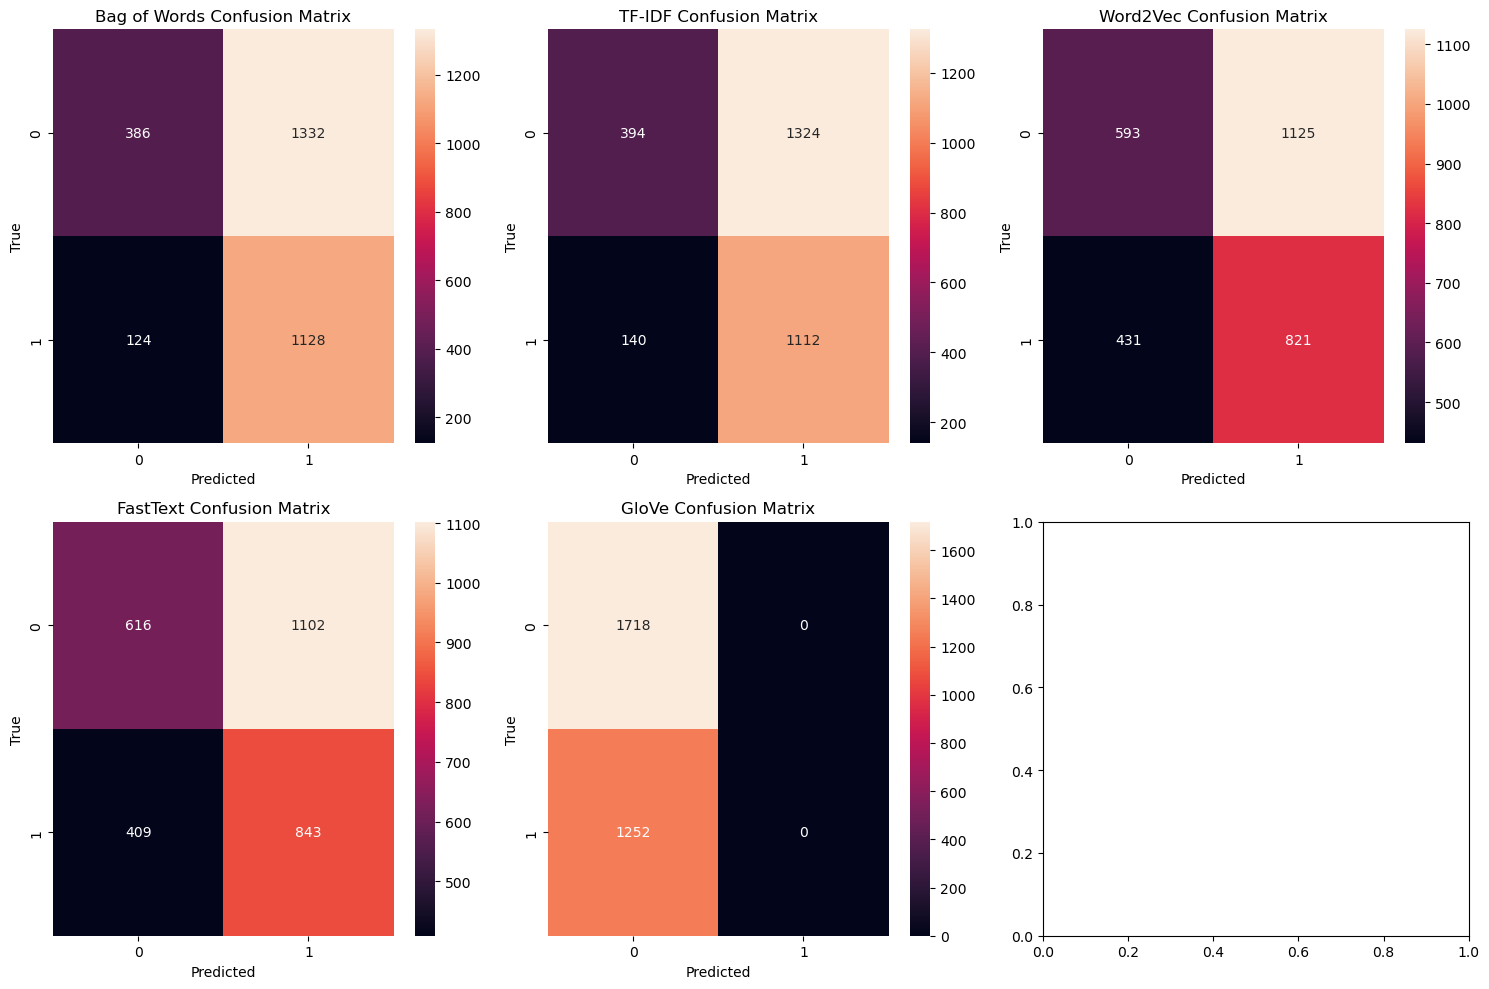

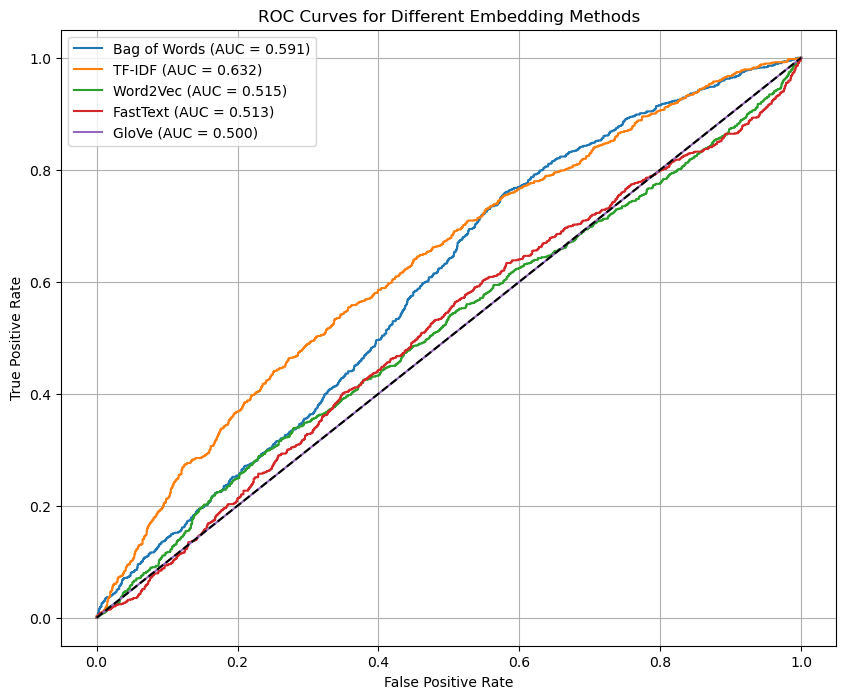

In [5]:
# Visualization functions
def evaluate_binary_classification(results):
    """Evaluate models specifically for hate speech detection"""
    evaluation = {}
    
    for method, result in results.items():
        evaluation[method] = {
            'Accuracy': result['accuracy'],
            'Hate Speech Detection Rate': result['1']['recall'],
            'False Positive Rate': 1 - result['0']['recall'],
            'Precision (Hate Speech)': result['1']['precision'],
            'F1 (Hate Speech)': result['1']['f1-score']
        }
    
    return pd.DataFrame(evaluation).round(3).T

def plot_confusion_matrices(results, y_test):
    """Plot confusion matrices for all methods"""
    n_methods = len(results)
    fig, axes = plt.subplots(2, (n_methods + 1) // 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, (method, result) in enumerate(results.items()):
        cm = confusion_matrix(y_test, result['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[idx])
        axes[idx].set_title(f'{method} Confusion Matrix')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('True')
    
    plt.tight_layout()
    plt.show()

def plot_roc_curves(results, y_test):
    """Plot ROC curves for all methods"""
    plt.figure(figsize=(10, 8))
    
    for method, result in results.items():
        fpr, tpr, _ = roc_curve(y_test, result['probabilities'][:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{method} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Different Embedding Methods')
    plt.legend()
    plt.grid(True)
    plt.show()

# Generate and display results
hate_speech_metrics = evaluate_binary_classification(results)
display(hate_speech_metrics)
plot_confusion_matrices(results, test_df['label'])
plot_roc_curves(results, test_df['label'])